In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe

     |████████████████████████████████| 32.7 MB 1.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import os
import glob

In [ ]:
CAM_NO = 0
CONTROL_KEYBOARD = True
UP_ROLL_FRAME = 4
UP_THRESH_MIN_Y_DELTA = 0.35
UP_THRESH_MIN_SD = 0.90
DOWN_THRESH_MAX_SD = 0.70
DOWN_AFTER_DELAY = 10

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [ ]:
LANDMARKS_LEFT_HAND = [
    mp_pose.PoseLandmark.LEFT_WRIST,
    mp_pose.PoseLandmark.LEFT_PINKY,
    mp_pose.PoseLandmark.LEFT_INDEX,
    mp_pose.PoseLandmark.LEFT_THUMB
]
LANDMARKS_RIGHT_HAND = [
    mp_pose.PoseLandmark.RIGHT_WRIST,
    mp_pose.PoseLandmark.RIGHT_PINKY,
    mp_pose.PoseLandmark.RIGHT_INDEX,
    mp_pose.PoseLandmark.RIGHT_THUMB
]
LANDMARKS_SHOULDER = [
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]
LANDMARKS_ELBOW = [
    mp_pose.PoseLandmark.LEFT_ELBOW,
    mp_pose.PoseLandmark.RIGHT_ELBOW
]
LANDMARKS_HIP = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP
]
LANDMARKS_KNEE = [
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE
]
LANDMARKS_UPPERBODY = LANDMARKS_ELBOW + LANDMARKS_HIP
LANDMARKS_LOWERBODY = [i for i in range(23, 33)]

In [ ]:
# Turn landmark dictionary to numpy array
# Also reverse y coordinate
def landmarks2numpy(image_landmarks, discard_visibility=False):
    if discard_visibility:
        arr = [[l.x, -l.y, l.z] for l in image_landmarks]
    else:
        arr = [[l.x, -l.y, l.z, l.visibility] for l in image_landmarks]
    return np.array(arr)

# Unnormalize x,y components of each landmark
def landmark_array_unnormalize(arr, width, height, inplace=True):
    if not inplace:
        arr = arr.copy()
    arr[:, 0] *= width
    arr[:, 1] *= height
    return arr

# Pose classifier
# Input should be unnormalized
def pose_classify(landmark_coor, image_width, image_height):
    # Coupling limbs
    y_left_hand = landmark_coor[np.ix_(LANDMARKS_LEFT_HAND, [1])].mean()
    y_right_hand = landmark_coor[np.ix_(LANDMARKS_RIGHT_HAND, [1])].mean()
    y_shoulder = landmark_coor[np.ix_(LANDMARKS_SHOULDER, [1])].mean()
    y_elbow = landmark_coor[np.ix_(LANDMARKS_ELBOW, [1])].mean()
    y_knee = landmark_coor[np.ix_(LANDMARKS_KNEE, [1])].mean()
    y_hip = landmark_coor[np.ix_(LANDMARKS_HIP, [1])].mean()
    
    # Local unit distance
    x_dist_shoulder = landmark_coor[mp_pose.PoseLandmark.LEFT_SHOULDER, 0] - landmark_coor[mp_pose.PoseLandmark.RIGHT_SHOULDER, 0]
    y_dist_elbow_knee = y_elbow - y_knee
    
    # Stats
    y_upper_body = np.average([y_shoulder, y_hip])
    y_sd_lower_body = np.std(landmark_coor[np.ix_(LANDMARKS_LOWERBODY, [1])])
    
    # Rule based classification
    if y_right_hand > y_shoulder and y_left_hand < y_shoulder:
        return "Right"
    elif y_left_hand > y_shoulder and y_right_hand < y_shoulder:
        return "Left"
    elif y_sd_lower_body / x_dist_shoulder < DOWN_THRESH_MAX_SD:
        return "Under"
    else:
        return "Idle"

In [ ]:
folder_name = ["Left", "Right", "Under"]
classes = ["Left", "Right", "Under", "Idle"]
extension = [".png", ".jpg"]
conf_mat = np.zeros((3, 4))
preds = []
labels = []
miss = []

for name in folder_name:
  path = f"/content/drive/Shareddrives/computer-vision/dataset/{name}/"
  img_paths = os.listdir(path)
  folder_size = len(img_paths)
  print(len(img_paths))

  BG_COLOR = (192, 192, 192) # gray
  with mp_pose.Pose(
      static_image_mode=True,
      model_complexity=2,
      enable_segmentation=True,
      min_detection_confidence=0.5) as pose:
    for idx, filename in enumerate(img_paths):
      print(idx + 1, "/", folder_size, "from", name)
      image = cv2.imread(os.path.join(path, filename))
      image_height, image_width, _ = image.shape
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      results = pose.process(image)

      if not results.pose_landmarks:
        pose_result = "Idle"
      else:
        landmark_coor = landmarks2numpy(results.pose_landmarks.landmark)
        landmark_array_unnormalize(landmark_coor, image_width, image_height)
        pose_result = pose_classify(landmark_coor, image_width, image_height)
      
      if pose_result != name:
        miss.append(os.path.join(path, filename))
      
      pred_id = classes.index(pose_result)
      label_id = classes.index(name)
      preds.append(pose_result)
      labels.append(name)
      conf_mat[label_id, pred_id] += 1

124
1 / 124 from Left
2 / 124 from Left
3 / 124 from Left
4 / 124 from Left
5 / 124 from Left
6 / 124 from Left
7 / 124 from Left
8 / 124 from Left
9 / 124 from Left
10 / 124 from Left
11 / 124 from Left
12 / 124 from Left
13 / 124 from Left
14 / 124 from Left
15 / 124 from Left
16 / 124 from Left
17 / 124 from Left
18 / 124 from Left
19 / 124 from Left
20 / 124 from Left
21 / 124 from Left
22 / 124 from Left
23 / 124 from Left
24 / 124 from Left
25 / 124 from Left
26 / 124 from Left
27 / 124 from Left
28 / 124 from Left
29 / 124 from Left
30 / 124 from Left
31 / 124 from Left
32 / 124 from Left
33 / 124 from Left
34 / 124 from Left
35 / 124 from Left
36 / 124 from Left
37 / 124 from Left
38 / 124 from Left
39 / 124 from Left
40 / 124 from Left
41 / 124 from Left
42 / 124 from Left
43 / 124 from Left
44 / 124 from Left
45 / 124 from Left
46 / 124 from Left
47 / 124 from Left
48 / 124 from Left
49 / 124 from Left
50 / 124 from Left
51 / 124 from Left
52 / 124 from Left
53 / 124 from Lef

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        Idle     0.0000    0.0000    0.0000         0
        Left     1.0000    0.9758    0.9878       124
       Right     1.0000    1.0000    1.0000       136
       Under     1.0000    0.9688    0.9841        96

    accuracy                         0.9831       356
   macro avg     0.7500    0.7361    0.7430       356
weighted avg     1.0000    0.9831    0.9915       356



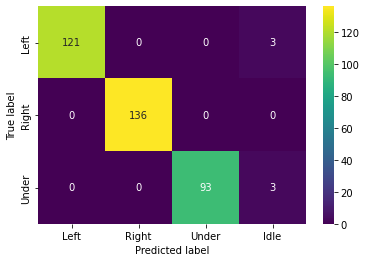

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

print(classification_report(labels, preds, digits=4))

df_cm = pd.DataFrame(conf_mat, index=folder_name, columns=classes)
sns.heatmap(df_cm, annot=True, cmap="viridis", fmt="g")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

/content/drive/Shareddrives/computer-vision/dataset/Left/frame0074.png


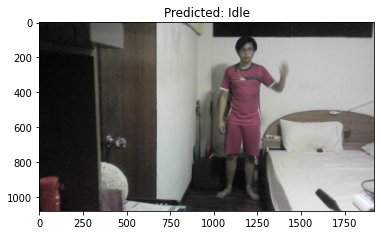

/content/drive/Shareddrives/computer-vision/dataset/Left/frame0061.png


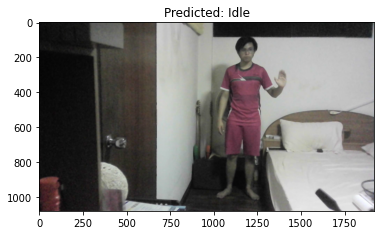

/content/drive/Shareddrives/computer-vision/dataset/Left/frame0060.png


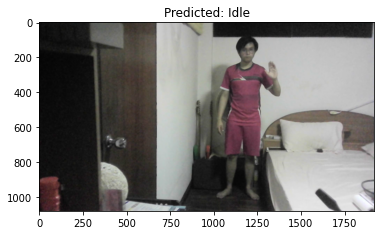

/content/drive/Shareddrives/computer-vision/dataset/Under/frame0133.png


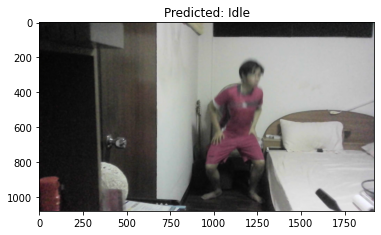

/content/drive/Shareddrives/computer-vision/dataset/Under/poom018.jpg


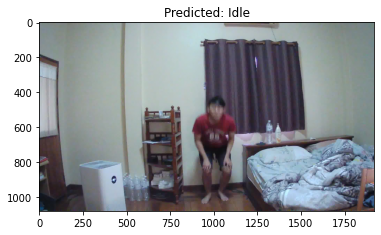

/content/drive/Shareddrives/computer-vision/dataset/Under/poom078.jpg


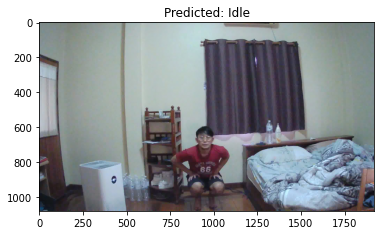

In [ ]:
with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
  for idx, path in enumerate(miss):
    image = cv2.imread(path)
    image_height, image_width, _ = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)

    if not results.pose_landmarks:
      pose_result = "Idle"
    else:
      landmark_coor = landmarks2numpy(results.pose_landmarks.landmark)
      landmark_array_unnormalize(landmark_coor, image_width, image_height)
      pose_result = pose_classify(landmark_coor, image_width, image_height)
    
    print(path)
    plt.imshow(image)
    plt.title("Predicted: " + pose_result)
    plt.show()